In [ ]:
# ! pip uninstall surface_erasure_decoding
# ! pip3 install git+https://github.com/JiakaiW/surface_erasure_decoding

In [1]:
from surface_erasure_decoding import sur_job
import uuid
import itertools
import pickle
import zipfile
import os
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import json
import datetime
import numpy as np

unsaturated_colors = {
    'red': {
        3: (0.86, 0.371, 0.339),
        5: (0.8, 0.251, 0.231),
        7: (0.71, 0.086, 0.063),
        9: (0.64, 0.051, 0.051),
        11: (0.53, 0.035, 0.035),
        13: (0.43, 0.024, 0.024)
    },
    'blue': {
        3: (0.353, 0.678, 0.901),
        5: (0.255, 0.502, 0.701),
        7: (0.157, 0.322, 0.502),
        9: (0.086, 0.231, 0.365),
        11: (0.063, 0.184, 0.325),
        13: (0.039, 0.137, 0.286)
    },
    'green': {
        3: (0.467, 0.775, 0.459),
        5: (0.376, 0.686, 0.373),
        7: (0.286, 0.596, 0.286),
        9: (0.216, 0.51, 0.216),
        11: (0.169, 0.435, 0.169),
        13: (0.133, 0.365, 0.133)
    },
    'light_purple': {
        3: (0.659, 0.486, 0.756),
        5: (0.557, 0.376, 0.647),
        7: (0.467, 0.278, 0.549),
        9: (0.388, 0.192, 0.459),
        11: (0.318, 0.118, 0.384),
        13: (0.259, 0.059, 0.318)
    }
}


In [2]:
# d_to_shots = {3: int(1e5), # 5,000s, 83min
#               5:int(2e4), # 10,500s, 175 min
#               7:int(1e4), # 5,500 s, 91 min
#               9: int(1e4), # 11,000 s, 180 min
#               11: int(1e4) # 20700 s, 360 min
#               }# =>900 min per parameter set

distance_to_sec_per_shot = {
    3:0.1,
    5:0.2,
    7:0.5,
    9:1,
    11:2
}

qbt_lifetime_array: ['1.00e-02', '1.51e-02', '2.28e-02', '3.43e-02', '5.18e-02', '7.81e-02', '1.18e-01', '1.78e-01', '2.68e-01', '4.05e-01', '6.11e-01', '9.21e-01', '1.39e+00', '2.10e+00', '3.16e+00']
p_p_array: [2.00000000e-02 1.32574063e-02 8.78794112e-03 5.82526531e-03
 3.86139546e-03 2.55960443e-03 1.69668580e-03 1.12468265e-03
 7.45518744e-04 4.94182246e-04 3.27578741e-04 2.17142224e-04
 1.43937135e-04 9.54116539e-05 6.32455532e-05]
decay_lifetime_array: ['2.00e-03', '2.84e-03', '4.05e-03', '5.77e-03', '8.23e-03', '1.17e-02', '1.67e-02', '2.38e-02', '3.39e-02', '4.84e-02', '6.89e-02', '9.82e-02', '1.40e-01', '2.00e-01']
p_e_array: [0.10023745 0.070337   0.04935574 0.03463311 0.02430219 0.01705294
 0.01196611 0.00839667 0.00589197 0.00413442 0.00290114 0.00203574
 0.00142849 0.00100237]


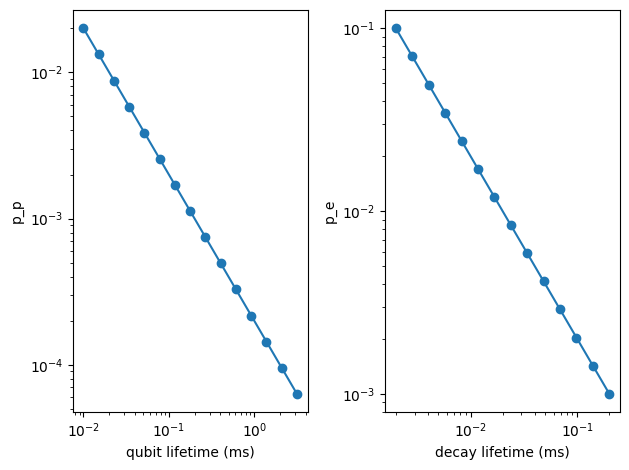

In [9]:
gate_time = 200*1e-6 # ms
qbt_lifetime_array = 10 ** np.linspace(-2,0.5,15) # ms
formatted_floats = [f"{num:.2e}" for num in qbt_lifetime_array]
print(f"qbt_lifetime_array: {formatted_floats}")

p_p_array = gate_time / qbt_lifetime_array
print(f"p_p_array: {p_p_array}")

fig, axes = plt.subplots(1,2)
axes[0].plot(qbt_lifetime_array,p_p_array,marker = 'o')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('qubit lifetime (ms)')
axes[0].set_ylabel('p_p')


decay_lifetime_array = 10 ** np.linspace(-2.7,-0.7,14)# ms
formatted_floats = [f"{num:.2e}" for num in decay_lifetime_array]
print(f"decay_lifetime_array: {formatted_floats}")

p_e_array = gate_time / decay_lifetime_array
print(f"p_e_array: {p_e_array}")

axes[1].plot(decay_lifetime_array,p_e_array,marker = 'o')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('decay lifetime (ms)')
axes[1].set_ylabel('p_e')


plt.tight_layout()

p_e_list = list(p_e_array)
p_z_shift_list = [0.0]
p_m_list = [0.0]
p_p_list = list(p_p_array)


In [10]:
p_p_list_subset = p_p_list[5:]
p_p_list_subset

[0.0025596044279959074,
 0.0016966857964881442,
 0.001124682650380698,
 0.0007455187440629879,
 0.0004941822455971208,
 0.00032757874139081276,
 0.00021714222388044075,
 0.00014393713460023042,
 9.541165392287853e-05,
 6.324555320336758e-05]

In [11]:
p_e_list_subset = p_e_list[3:]
p_e_list_subset

[0.03463311333724167,
 0.02430218822751778,
 0.017052938524317534,
 0.01196611225259428,
 0.008396666781944982,
 0.005891973228960217,
 0.004134420173184783,
 0.0029011384648558285,
 0.0020357399682922515,
 0.0014284865299279965,
 0.0010023744672545444]

In [12]:

combinations = list(itertools.product(p_e_list_subset, 
                                      p_z_shift_list,
                                      p_m_list,
                                      p_p_list_subset))
print(f"num combinations {len(combinations)}, num jobs (for all distances) per combination with 1e4 jobs tot cap: {int(1e4/len(combinations))}")


num combinations 110, num jobs (for all distances) per combination with 1e4 jobs tot cap: 90


In [14]:
shots_per_d9_job  = 15000
d_to_num_shots_per_job = {
    9: shots_per_d9_job,
    7: shots_per_d9_job * 2 ,
    5: shots_per_d9_job * 4,
    3: shots_per_d9_job * 8,
}

print(f"time per job: {shots_per_d9_job * distance_to_sec_per_shot[9]} sec, in minutes: {shots_per_d9_job * distance_to_sec_per_shot[9] / 60}")

d_to_num_jobs = {
    9: 63,
    7: 20,
    5: 6,
    3: 1
}

print(f"d3 tot shots {d_to_num_shots_per_job[3] * d_to_num_jobs[3]}")
print(f"d5 tot shots {d_to_num_shots_per_job[5] * d_to_num_jobs[5]}")
print(f"d7 tot shots {d_to_num_shots_per_job[7] * d_to_num_jobs[7]}")
print(f"d9 tot shots {d_to_num_shots_per_job[9] * d_to_num_jobs[9]}")


time per job: 15000 sec, in minutes: 250.0
d3 tot shots 120000
d5 tot shots 360000
d7 tot shots 600000
d9 tot shots 945000


In [15]:
counter = 0
jobs_info = []

for (p_e,p_z_shift,p_m,p_p) in combinations:
    for d in [3,5,7,9]:
        num_jobs = d_to_num_jobs[d]
        num_shots_per_job = d_to_num_shots_per_job[d]
        
        circuit_id=str(uuid.uuid4())
        for _ in range(num_jobs):
            job_id=str(uuid.uuid4())
            job = sur_job.Sample_decode_job(
                            job_id=job_id,
                            circuit_id=circuit_id,
                            d = d,
                            p_e=p_e,
                            p_z_shift= p_z_shift,
                            p_p=p_p,
                            p_m = p_m,
                            shots=num_shots_per_job,
                            )
            with open(f"{counter}.pkl", "wb") as f:
                pickle.dump(job, f)
            counter += 1

            jobs_info.append({
                "job_id": job_id,
                "circuit_id": circuit_id,
                "d": d,
                "p_e": p_e,
                "p_z_shift": p_z_shift,
                "p_p": p_p,
                "p_m": p_m,
                "shots": num_shots_per_job,
                "file": f"{counter}.pkl"
            })
print(f"num_jobs: {counter}")

# Save jobs information to a JSON file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"jobs_info_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json.dump(jobs_info, json_file, indent=4)

def pack_pkl_files_to_zip(zip_filename="erasure_input.zip"):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in os.listdir('.'):
            name, ext = os.path.splitext(filename)
            if ext == '.pkl' and name.isdigit():
                zipf.write(filename)
                os.remove(filename)
                
pack_pkl_files_to_zip()

num_jobs: 9900


In [16]:
import os
import json
import pandas as pd

json_list = []
directory = "erasure_decode_result_v2"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

directory = "erasure_decode_result_v2_additional_shots"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

df = pd.DataFrame(json_list)


In [17]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'shots': 'sum',
    'new_circ': 'sum',
    # 'normal': 'sum',
    'p_e': 'first',
    'p_z_shift': 'first',
    'p_p': 'first',
    'p_m': 'first',
}

df_grouped = df.groupby(['circuit_id', 'd']).agg(agg_rules).reset_index()
df_grouped['p_logi_era'] = df_grouped['new_circ'] / df_grouped['shots']
# df_grouped['p_logi_normal'] = df_grouped['normal'] / df_grouped['shots']


In [18]:
# After grouping there should be 14 * 15 * 4 = 840 rows.
df_grouped

,circuit_id,d,shots,new_circ,p_e,p_z_shift,p_p,p_m,p_logi_era
0,00278c84-a2a7-4259-a419-ad11ee3b155e,5,360000,1,0.005892,0.0,0.000095,0.0,0.000003
1,00303a1d-e4e2-4eea-b369-df2c7ee44c16,7,160000,15625,0.017053,0.0,0.013257,0.0,0.097656
2,0031a513-89d8-4b60-a35f-5b0cabeb9d13,5,96000,1,0.008397,0.0,0.000063,0.0,0.000010
3,003a9f8f-9ce7-4309-aea8-f95d40cda647,5,96000,3,0.024302,0.0,0.000063,0.0,0.000031
4,003d693e-1a6b-490e-841f-752ec63e4cbd,7,600000,6,0.017053,0.0,0.000494,0.0,0.000010
...,...,...,...,...,...,...,...,...,...
1275,ff0f1b1c-b6c9-4691-a96d-a8c3b099300b,5,96000,21,0.034633,0.0,0.000095,0.0,0.000219
1276,ff491f10-beea-4759-9c38-1f358574a84c,3,120000,28,0.004134,0.0,0.000328,0.0,0.000233
1277,ff906180-8e93-4425-82ea-0c8e53bf8e93,7,160000,66219,0.070337,0.0,0.020000,0.0,0.413869
1278,ffce9a89-9569-448d-913e-191373cb6200,5,96000,550,0.001002,0.0,0.005825,0.0,0.005729


In [19]:
def compute_binary_confidence_interval(num_positive, n_samples, confidence_level=0.95):
    p_hat = num_positive / n_samples  # Estimated probability
    standard_error = math.sqrt((p_hat * (1 - p_hat)) / n_samples)
    z = 1.96  # For a 95% confidence level
    margin_of_error = z * standard_error
    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error
    lower_bound = max(0,lower_bound)
    return lower_bound, upper_bound


In [20]:
def plot_logi_vs_intrin(p_e,p_m, p_z_shift):
    df = df_grouped
    filtered_df = df.loc[(df['p_e'] == p_e) &
                         (df['p_m'] == p_m) &
                         (df['p_z_shift'] == p_z_shift)]

    group_by_columns = ['d']        

    for _, group in filtered_df.groupby(group_by_columns):
        distance = group.iloc[0]['d']
        x_values = group['p_p']
        y_values = group['p_logi_era']

        x_y_values = zip(x_values, y_values)
        sorted_xy_values = sorted(x_y_values, key=lambda v: v[0])
        sorted_x, sorted_y = zip(*sorted_xy_values)
        color = unsaturated_colors['blue'].get(distance, 'blue')
        plt.plot(sorted_x, sorted_y, color=color, label=f'd_{distance}_conditional_prob_decoding')
        
        # CI
        m = group['new_circ']
        n = group['shots']
        m_n_x_values = zip(m, n,x_values)
        sorted_mn_values = sorted(m_n_x_values, key=lambda v: v[-1])
        sorted_m, sorted_n,sorted_x = zip(*sorted_mn_values)
        num_positive = sorted_m
        n_samples = sorted_n
        lower_bound, upper_bound = zip(*[compute_binary_confidence_interval(num, n) for num, n in zip(num_positive, n_samples)])
        plt.fill_between(sorted_x, lower_bound, upper_bound, color=color, alpha=0.3)

    # Set log scales for both x and y axes
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    # Set plot labels and legend
    plt.title(f'leakage{p_e},p_z from shift{p_z_shift}')
    plt.xlabel('p_intrin')
    plt.ylabel('Per shot logical error')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




def make_logi_vs_intrin_widget():
    interactive_plot = interactive(plot_logi_vs_intrin,
                p_e = p_e_list,
                p_m = p_m_list,
                p_z_shift = p_z_shift_list)
    return interactive_plot


make_logi_vs_intrin_widget()

interactive(children=(Dropdown(description='p_e', options=(0.10023744672545448, 0.07033700014339496, 0.0493557…

# Now I have a dataframe that describe p_logi_era as a function of d, p_e, p_p, (and p_m). I want to know if a (p_e, p_p) is above or below the threshold.

In [35]:
import numpy as np

print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
distances = [3,5,7,9]
slope_array = []
for p_e in p_e_list:
    slope_array.append([])
    for p_p in p_p_list:
        p_log = []
        for d in distances:
            p_log.append(
                df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e) &
                        (df_grouped['p_p'] == p_p) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
            )

        slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)
        formatted_floats = [f"{num:.2e}" for num in p_log]
        # print(f"p_log: {formatted_floats}, base = {slope}")
        slope_array[-1].append(slope)
    
slope_array = np.array(slope_array)

num p_e 14, num p_p 15


/var/folders/9k/z8bpg3hj3d9841ggs75xmwxw0000gn/T/ipykernel_33993/126973211.py:19: RuntimeWarning: divide by zero encountered in log
  slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)


In [47]:
def plot_scaling(p_e_idx, p_p_idx):
    assert p_e_idx < len(p_e_list)
    assert p_p_idx < len(p_p_list)
    p_log = []
    for d in distances:
        p_log.append(
            df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
        )
    print(f"p_e: {p_e_list[p_e_idx]}, p_p: {p_p_list[p_p_idx]}")
    plt.plot(distances,np.log(p_log))

p_e: 0.005891973228960217, p_p: 0.0016966857964881442


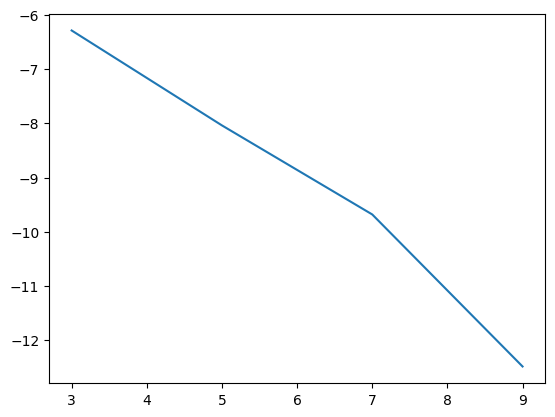

In [68]:
plot_scaling(-6,6)

In [32]:
# import numpy as np

# print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
# distances = [3,5,7,9]
# slope_array = []
# for p_e in p_e_list:
#     slope_array.append([])
#     for p_p in p_p_list:
#         p_log_list = []
#         distances_without_nan = []
#         for d in distances:
#             p_log = df_grouped.loc[(df_grouped['d'] == d) &
#                         (df_grouped['p_e'] == p_e) &
#                         (df_grouped['p_p'] == p_p) &
#                         (df_grouped['p_m'] == p_m_list[-1]) &
#                         (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
#             if p_log > 0:
#                 distances_without_nan.append(d)
#                 p_log_list.append(p_log)
#         if len(p_log_list)>1:
#             slope, intercept = np.polyfit(x=distances_without_nan, y=np.log(p_log_list), deg = 1)
#             formatted_floats = [f"{num:.2e}" for num in p_log_list]
#             print(f"p_log_list: {formatted_floats}, base = {slope}")
#             slope_array[-1].append(slope)
#         else:
#             slope_array[-1].append(np.nan)
    
# slope_array = np.array(slope_array)

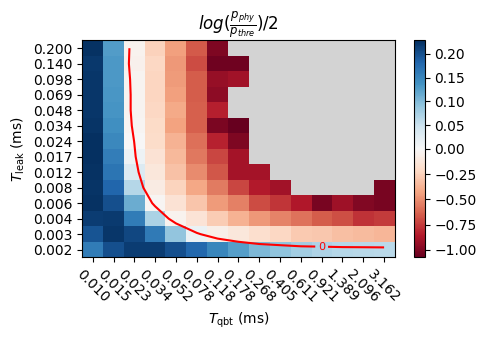

In [33]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize = (5,3.5))

plt.title(rf'$log(\frac{{p_{{phy}}}}{{p_{{thre}}}})/2$')
plt.xlabel(r'$T_\text{qbt}$ (ms)')
plt.ylabel(r'$T_\text{leak}$ (ms)')

temp_x = np.arange(len(qbt_lifetime_array))
temp_y = np.arange(len(decay_lifetime_array))
X, Y = np.meshgrid(temp_x, temp_y)
contour = plt.contour(X, Y, slope_array, levels=[0], colors='red')
plt.clabel(contour, inline=True, fontsize=8)


# cax = ax.imshow(slope_array, cmap= 'RdBu', norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_array),vcenter = 0,vmax = np.nanmax(slope_array)),
#         extent=[ qbt_lifetime_array[0], qbt_lifetime_array[-1],  decay_lifetime_array[0], decay_lifetime_array[-1]], aspect='auto',origin='lower')

cmap = plt.get_cmap('RdBu')
cmap = cmap(np.arange(cmap.N))
cmap[:, -1] = np.linspace(1, 1, cmap.shape[0])  # Set alpha to 1 for all colors
cmap = ListedColormap(cmap)
cmap.set_bad(color='lightgray')  # Set color for NaN values

cax = ax.imshow(slope_array, cmap= cmap, norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_array),vcenter = 0,vmax = np.nanmax(slope_array)),
        aspect='auto',origin='lower')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_ticks([-1,-0.75,-0.5,-0.25,0,0.05,0.1,0.15,0.2])


ax.set_xticks(temp_x)
ax.set_yticks(temp_y)
ax.set_xticklabels([f'{val:.3f}' for val in qbt_lifetime_array], rotation = -45)
ax.set_yticklabels([f'{val:.3f}' for val in decay_lifetime_array])
# ax.set_xscale('log')
# ax.set_yscale('log')

plt.tight_layout()
fig.savefig('threshold.pdf')


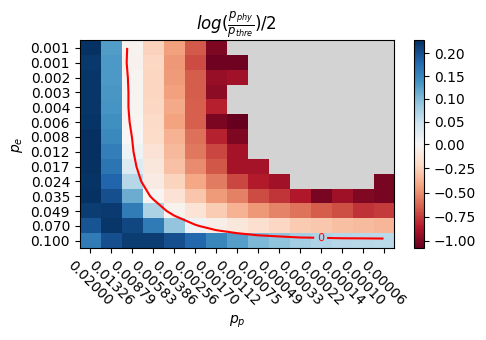

In [34]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize = (5,3.5))

plt.title(rf'$log(\frac{{p_{{phy}}}}{{p_{{thre}}}})/2$')
plt.xlabel(r'$p_p$')
plt.ylabel(r'$p_e$')

temp_x = np.arange(len(qbt_lifetime_array))
temp_y = np.arange(len(decay_lifetime_array))
X, Y = np.meshgrid(temp_x, temp_y)
contour = plt.contour(X, Y, slope_array, levels=[0], colors='red')
plt.clabel(contour, inline=True, fontsize=8)


cmap = plt.get_cmap('RdBu')
cmap = cmap(np.arange(cmap.N))
cmap[:, -1] = np.linspace(1, 1, cmap.shape[0])  # Set alpha to 1 for all colors
cmap = ListedColormap(cmap)
cmap.set_bad(color='lightgray')  # Set color for NaN values

cax = ax.imshow(slope_array, cmap= cmap, norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_array),vcenter = 0,vmax = np.nanmax(slope_array)),
        aspect='auto',origin='lower')
cbar = fig.colorbar(cax, ax=ax)
cbar.set_ticks([-1,-0.75,-0.5,-0.25,0,0.05,0.1,0.15,0.2])


ax.set_xticks(np.arange(len(p_p_list)))
ax.set_yticks(np.arange(len(p_e_list)))
xtick_labels = [f'{val:.5f}' for val in p_p_list[::]]
# for i in range(len(xtick_labels)):
#         if i%3 !=0:
#                 xtick_labels[i] = ''
ax.set_xticklabels(xtick_labels, rotation = -45)
ax.set_yticklabels([f'{val:.3f}' for val in p_e_list])
# ax.set_xscale('log')
# ax.set_yscale('log')

plt.tight_layout()
fig.savefig('threshold_pe_pp.pdf')
